In [1]:
import math
import numpy as np
import torch
import gpytorch as gp
import botorch as bo
from botorch.models.gpytorch import GPyTorchModel
import matplotlib.pyplot as plt
from scipy.stats import norm, ttest_ind, ttest_rel

In [2]:
class prior(gp.models.ExactGP, GPyTorchModel):
    def __init__(self, train_inputs, train_targets, likelihood, kernel):
        super().__init__(train_inputs, train_targets, likelihood)
        self.mean_module = gp.means.ConstantMean()
        self.covar_module = kernel
    
    def forward(self, x):
        mean = self.mean_module(x)
        covar = self.covar_module(x)
        return gp.distributions.MultivariateNormal(mean, covar)
        

def camel(x1, x2):
    ans = (4 - 2.1*x1**2 + x1**4/3)*x1**2
    ans += x1*x2
    ans += (-4 + 4*x2**2)*x2**2
    return ans

def a_ei(fmin, mean, std):
    ans = (fmin - mean) * norm.cdf((fmin - mean)/std)
    ans += std * norm.pdf((fmin - mean)/std)
    return ans

def gap(best_found, best_init, best):
    ans = (best_found - best_init)/(best - best_init)
    return ans

In [3]:
num = 1000
domain1 = torch.linspace(-3, 3, num)
domain2 = torch.linspace(-2, 2, num)
x1, x2 = torch.meshgrid(domain1, domain2, indexing="ij")
domain = torch.stack([x1.reshape(num*num, 1), x2.reshape(num*num, 1)], -1).squeeze(1)
f = torch.log(camel(domain[:, 0], domain[:, 1]) + 1.2)

num_runs = 20
gaps = torch.zeros((num_runs, 30))
gaps_rand = torch.zeros((num_runs, 150))

for run in range(num_runs):
    D_idx = np.random.choice(num*num, 5, False)
    D_X = domain[D_idx]
    D_y = f[D_idx]
    D_fmin = torch.min(D_y)
    fmin_init = torch.min(D_y)
    best = math.log(-1.0316+1.2)

    D_X_rand = D_X.clone()
    D_y_rand = D_y.clone()
    D_fmin_rand = torch.min(D_y_rand)

    budget = 30
    for t in range(budget):
        # Initialize model
        likelihood = gp.likelihoods.FixedNoiseGaussianLikelihood(noise=torch.ones(D_X.shape[0])*(0.01**2))
        k = gp.kernels.ScaleKernel(gp.kernels.RBFKernel())
        k.outputscale = 2.2065
        k.base_kernel.lengthscale = 0.9387
        model = prior(D_X, D_y, likelihood, k)
        model.mean_module.constant = torch.nn.parameter.Parameter(torch.tensor(3.4147))

        # Measure EI
        model.eval()
        likelihood.eval()
        with torch.no_grad(), gp.settings.fast_pred_var():
            f_preds = likelihood(model(domain), noise=torch.ones(domain.shape[0]) * (0.01**2))
        f_means = f_preds.mean.detach().numpy()
        f_stds = torch.sqrt(f_preds.variance).detach().numpy()
        a_eis = a_ei(D_fmin, f_means, f_stds)

        # Find Max EI and Observe
        max_idx = torch.argmax(a_eis)
        next_X = domain[max_idx]
        next_y = f[max_idx]
        D_X = torch.cat((D_X, next_X.reshape(1, -1)), dim=0)
        D_y = torch.cat((D_y, next_y.reshape(1)))
        D_fmin = torch.min(D_y)

        # Store gap
        gaps[run, t] = gap(D_fmin, fmin_init, best)

    budget_rand = 150
    for t_rand in range(budget_rand):
        next_idx = np.random.choice(num*num, 1)
        next_X = domain[next_idx]
        next_y = f[next_idx]
        D_X_rand = torch.cat((D_X_rand, next_X.reshape(1, -1)), dim=0)
        D_y_rand = torch.cat((D_y_rand, next_y.reshape(1)))
        D_fmin_rand = torch.min(D_y_rand)
        gaps_rand[run, t_rand] = gap(D_fmin_rand, fmin_init, best)

mean_gaps = torch.mean(gaps, dim=0)
mean_gaps_rand = torch.mean(gaps_rand, dim=0)

[]

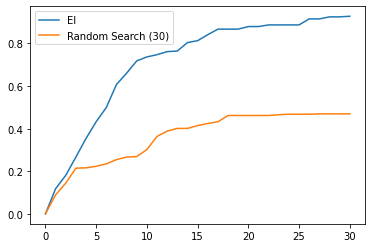

In [4]:
plt.plot(np.arange(0, 31), torch.cat((torch.zeros(1), mean_gaps)), label='EI')
plt.plot(np.arange(0, 31), torch.cat((torch.zeros(1), mean_gaps_rand[:30])), label='Random Search (30)')
plt.legend()
plt.plot()

In [5]:
print(ttest_ind(mean_gaps, mean_gaps_rand[:30], alternative="greater"))
print(ttest_ind(mean_gaps, mean_gaps_rand[30:60], alternative="greater"))
print(ttest_ind(mean_gaps, mean_gaps_rand[60:90], alternative="greater"))
print(ttest_ind(mean_gaps, mean_gaps_rand[90:120], alternative="greater"))
print(ttest_ind(mean_gaps, mean_gaps_rand[120:150], alternative="greater"))

Ttest_indResult(statistic=7.470580014716855, pvalue=2.37167507629908e-10)
Ttest_indResult(statistic=4.462033827950895, pvalue=1.895781027663742e-05)
Ttest_indResult(statistic=1.982929177070751, pvalue=0.02605888578781347)
Ttest_indResult(statistic=0.1652872701903347, pvalue=0.43464632116812896)
Ttest_indResult(statistic=-1.0451264653133188, pvalue=0.8498495738510154)
